<a href="https://colab.research.google.com/github/jmcaussade/Xinergy_Clasificacion_glosas/blob/main/Comparaci%C3%B3n_modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importar dependencias

In [1]:
!pip install nltk
!pip install pyspellchecker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 103.1 MB/s eta 0:00:00


In [2]:
import io
import copy
import torch
import json
import torch
import os
import nltk
import warnings
import re
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from nltk.corpus import stopwords
from nltk import pos_tag
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import _LRScheduler
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from torch.utils.data import DataLoader
from spellchecker import SpellChecker
from sklearn.preprocessing import LabelEncoder
from transformers import (AutoConfig,
                          AutoModelForSequenceClassification,
                          AutoTokenizer,AutoModel, AdamW,
                          get_linear_schedule_with_warmup,
                          set_seed,
                          )
from sklearn.utils.class_weight import compute_class_weight

tqdm.pandas()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

warnings.filterwarnings("ignore", category=UserWarning)



#Montar Drive

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


#Preprocesamiento

## Cargar Datos

In [38]:
ruta_data_set = '/content/drive/MyDrive/Xinergy/Proyecto_Clasificacion_Glosa/Version1/Inchcape_glosas_FM_1.xlsx'
df = pd.read_excel(ruta_data_set, sheet_name='Hoja1 (2)')
df.head()
df = df.iloc[:, :2]
df

,glosa,categoria
0,Arriendo maquina dispensadora,"Agua, Café y Vending"
1,Arriendo maquina dispensadora Abril,"Agua, Café y Vending"
2,Arriendo mensual QWS-Rirewall3 01/2023,"Agua, Café y Vending"
3,Arriendo mensual QWS-Rirewall3 02/2023,"Agua, Café y Vending"
4,Arriendo mensual QWS-Rirewall3 03/2023,"Agua, Café y Vending"
...,...,...
7837,Plan Cafe RRHH INCHSPACE Feb 23,"Agua, Café y Vending"
7838,Plan Cafe Taller -1 Feb 21,"Agua, Café y Vending"
7839,PLan Cafe Taller -1 Sept 23,"Agua, Café y Vending"
7840,Plan Cafe Taller Lonquen Feb 23,"Agua, Café y Vending"


## Analisis exploratorio

In [39]:
# Count the number of unique categories
num_classes = df['categoria'].nunique()

# Print the number of categories
print(f"Number of unique categories: {num_classes}")

# To also see the distribution of categories, you can keep the groupby:
category_counts = df.groupby('categoria').size()
print(category_counts.sort_values())



Number of unique categories: 24
categoria
Insumos de Oficina                           2
Ascensores                                  10
Limpieza y Aseo                             11
Inst. Sanitarias                            37
Electricidad                                60
Marketing y Branding                        67
Otros                                       84
Inst. Protección contra Incendio (PCI)     102
Alimentos Personal                         153
Control de Acceso                          185
Arriendos y Equipos                        205
Iluminación                                215
Gestión de Residuos                        227
Jardinería                                 232
Servicio de lavado                         249
Seguridad                                  322
Insumos y Consumibles                      380
Insumos de oficina                         492
HVAC                                       577
Mantención & Reparaciones                  619
Insumos Higiénicos

# Lable encoder

In [40]:
# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit the label encoder on the 'categoria' column of your training dataframe
label_encoder.fit(df['categoria'])

# Add a new column to your dataframe for the encoded labels
df['encoded_categoria'] = label_encoder.transform(df['categoria'])


In [42]:
df

,glosa,categoria,encoded_categoria
0,Arriendo maquina dispensadora,"Agua, Café y Vending",0
1,Arriendo maquina dispensadora Abril,"Agua, Café y Vending",0
2,Arriendo mensual QWS-Rirewall3 01/2023,"Agua, Café y Vending",0
3,Arriendo mensual QWS-Rirewall3 02/2023,"Agua, Café y Vending",0
4,Arriendo mensual QWS-Rirewall3 03/2023,"Agua, Café y Vending",0
...,...,...,...
7837,Plan Cafe RRHH INCHSPACE Feb 23,"Agua, Café y Vending",0
7838,Plan Cafe Taller -1 Feb 21,"Agua, Café y Vending",0
7839,PLan Cafe Taller -1 Sept 23,"Agua, Café y Vending",0
7840,Plan Cafe Taller Lonquen Feb 23,"Agua, Café y Vending",0


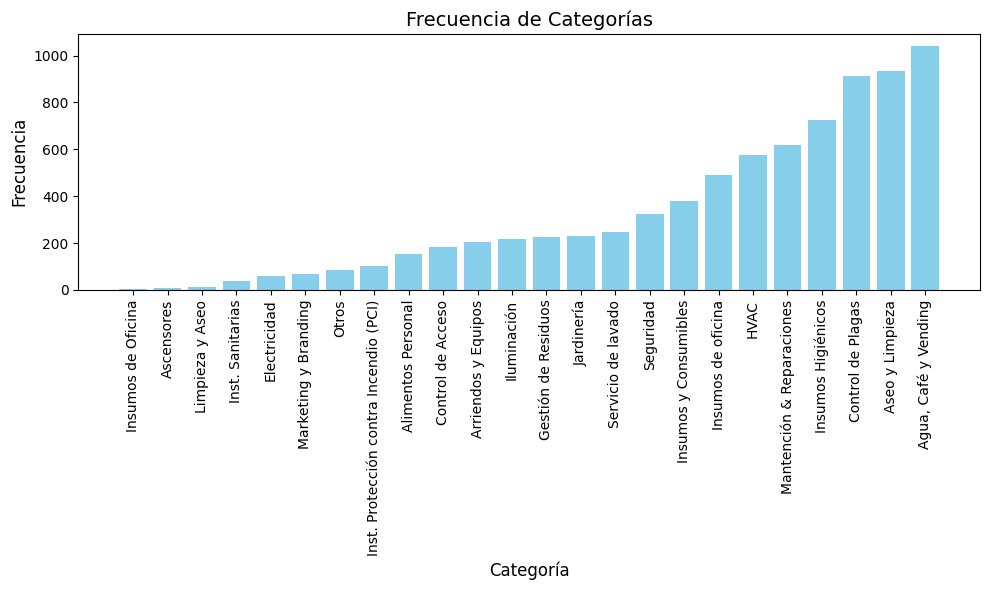

In [43]:
# Sort the counts in ascending order
category_counts = category_counts.sort_values()

# Plot the histogram
plt.figure(figsize=(10, 6))  # Set the figure size
plt.bar(category_counts.index, category_counts.values, color='skyblue')

# Add labels and title
plt.xlabel('Categoría', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.title('Frecuencia de Categorías', fontsize=14)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

# Show the plot
plt.tight_layout()
plt.show()

In [44]:
null_count = df['categoria'].isnull().sum()
print(f"Number of null values in 'categoria': {null_count}")


Number of null values in 'categoria': 0


In [45]:
df['glosa'] = df['glosa'].str.lower()

##Limpiar TODOS los caracteres de puntuación

In [11]:
# def limpiar1(texto):
#     puntuación = r'[,;.:¡!¿?@#$%&[\](){}<>~=+\-*/|\\_^`"\']'

#     # signos de puntuación
#     texto = re.sub(puntuación, ' ', texto)

#     # dígitos [0-9]
#     texto = re.sub('\d', ' ', texto)

#     return texto

##Limpiar ALGUNOS caracteres de puntuación

In [46]:
def limpiar2(texto):
    texto = re.sub(r'[^a-zA-Z0-9\s.,;:¡!¿?]', '', texto)

    # Remove digits [0-9]
    texto = re.sub(r'\d', '', texto)

    return texto

In [13]:
# def normalizar(texto):

#     # tildes y diacríticas
#     texto = re.sub('á', 'a', texto)
#     texto = re.sub('é', 'e', texto)
#     texto = re.sub('í', 'i', texto)
#     texto = re.sub('ó', 'o', texto)
#     texto = re.sub('ú', 'u', texto)
#     texto = re.sub('ü', 'u', texto)
#     texto = re.sub('ñ', 'n', texto)

#     return texto

In [47]:
def limpiar_meses(texto):
    meses = [
        'enero', 'ene', 'febrero', 'feb', 'marzo', 'abril', 'abr',
        'mayo', 'may', 'junio', 'jun', 'julio', 'jul', 'agosto',
        'septiembre', 'sept', 'octubre', 'oct', 'noviembre', 'nov',
        'diciembre', 'dic'
    ]
    for mes in meses:
        # Use word boundaries (\b) and ignore case
        texto = re.sub(rf'\b{mes}\b', '', texto, flags=re.IGNORECASE)
    return texto


In [48]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [16]:
# def rem_stopwords(tokens):
#     global tag_map
#     texto_final = []
#     for token, tag in pos_tag(tokens):
#         if token not in stopwords.words('spanish'):
#             texto_final.append(token)
#     # return ' '.join(texto_final)
#     return texto_final

# # Convertir a lambda
# spanish_stopwords = set(stopwords.words('spanish'))
# rem_stopwords2 = lambda tokens: [token for token, tag in pos_tag(tokens) if token not in spanish_stopwords]



In [17]:
def limpiar(df):
    df['glosa'] = df['glosa'].apply(limpiar2).apply(limpiar_meses)
    return df

### Para ejutar las funciones

In [49]:
df = limpiar(df)

In [50]:
df

,glosa,categoria,encoded_categoria
0,arriendo maquina dispensadora,"Agua, Café y Vending",0
1,arriendo maquina dispensadora,"Agua, Café y Vending",0
2,arriendo mensual qwsrirewall,"Agua, Café y Vending",0
3,arriendo mensual qwsrirewall,"Agua, Café y Vending",0
4,arriendo mensual qwsrirewall,"Agua, Café y Vending",0
...,...,...,...
7837,plan cafe rrhh inchspace,"Agua, Café y Vending",0
7838,plan cafe taller,"Agua, Café y Vending",0
7839,plan cafe taller,"Agua, Café y Vending",0
7840,plan cafe taller lonquen,"Agua, Café y Vending",0


## Revisión ortografía

In [20]:
# # Initialize the spell checker
# spell = SpellChecker(language='es')  # Set language to Spanish

# # Define a function to correct misspelled words in a string
# def correct_misspelled_words(text):
#     # Tokenize the text into words
#     words = text.split()

#     # Identify misspelled words
#     misspelled = spell.unknown(words)

#     # Correct the misspelled words and replace them in the text
#     corrected_text = []
#     for word in words:
#         if word in misspelled:
#             # If a correction is found, use it, otherwise use the original word
#             corrected_word = spell.correction(word) or word
#             corrected_text.append(corrected_word)
#         else:
#             corrected_text.append(word)  # Keep the original word

#     # Join the corrected words back into a string
#     return ' '.join(corrected_text)

In [21]:
# # Apply the correction function to the "glosa" column with a progress bar
# df['glosa_corrected'] = df['glosa'].progress_apply(correct_misspelled_words)


#Definir Hiperparámetros

In [51]:
max_length = 512
epochs = 5
batch_size = 8
n_labels = 3
warmup_epochs = 0.2 * epochs
learning_rate = 1e-5

#Modelos

In [52]:
from google.colab import userdata
access_token = userdata.get('HuggingFace')

In [53]:
print(f"num_classes: {num_classes}")

num_classes: 24


In [54]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

models_list = [
    {
        "name": "BERT",
        "tokenizer": AutoTokenizer.from_pretrained("bert-base-multilingual-cased"),
        "model": AutoModelForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=num_classes)
    },
    {
        "name": "BETO",
        "tokenizer": AutoTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-cased"),
        "model": AutoModelForSequenceClassification.from_pretrained("dccuchile/bert-base-spanish-wwm-cased", num_labels=num_classes)
    },
    {
        "name": "PATANA",
        "tokenizer": AutoTokenizer.from_pretrained("PlanTL-GOB-ES/roberta-base-bne"),
        "model": AutoModelForSequenceClassification.from_pretrained("PlanTL-GOB-ES/roberta-base-bne", num_labels=num_classes)
    },
    {
        "name": "TULIO",
        "tokenizer": AutoTokenizer.from_pretrained("PlanTL-GOB-ES/roberta-large-bne"),
        "model": AutoModelForSequenceClassification.from_pretrained("PlanTL-GOB-ES/roberta-large-bne", num_labels=num_classes)
    },
    {
        "name": "RoBERTa",
        "tokenizer": AutoTokenizer.from_pretrained("roberta-base"),
        "model": AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=num_classes)
    },
    {
        "name": "ALBERT",
        "tokenizer": AutoTokenizer.from_pretrained("dccuchile/albert-xlarge-spanish"),
        "model": AutoModelForSequenceClassification.from_pretrained("dccuchile/albert-xlarge-spanish", num_labels=num_classes)
    },
    {
        "name": "DeBERTa",
        "tokenizer": AutoTokenizer.from_pretrained("microsoft/deberta-v3-base"),
        "model": AutoModelForSequenceClassification.from_pretrained("microsoft/deberta-v3-base", num_labels=num_classes)
    }
]




Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at PlanTL-GOB-ES/roberta-base-bne and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to

# Split

In [55]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=1)

In [56]:
class DatasetFromDataFrame(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=512):
        self.data = dataframe
        self.tokenizer = tokenizer  # The tokenizer for the model (e.g., BERT, RoBERTa)
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
          # Get the text and label
          text = str(self.data.iloc[index]['glosa'])  # 'glosa' is the text column
          label = int(self.data.iloc[index]['encoded_categoria'])  # 'categoria' is the label column

          # Tokenize the text
          inputs = self.tokenizer(
              text,                      # The text to classify
              max_length=self.max_length, # Pad or truncate to a fixed length
              padding='max_length',       # Ensure all texts are of the same length
              truncation=True,            # Truncate longer texts
              return_tensors="pt"         # Return PyTorch tensors
          )

          # The tokenized data (input_ids, attention_mask)
          input_ids = inputs['input_ids'].squeeze()  # Flatten the batch dimension (tensor to single tensor)
          attention_mask = inputs['attention_mask'].squeeze()  # Flatten attention mask

          # Return as a dictionary for easier access
          return {
              'input_ids': input_ids,
              'attention_mask': attention_mask,
              'labels': label
          }



In [57]:
def tokenize_dataframe(dataframe, tokenizer, max_length=512):
    # Initialize lists for tokenized inputs and labels
    tokenized_data = []

    # Iterate through the DataFrame and tokenize each text
    for index, row in dataframe.iterrows():
        text = row['glosa']
        label = row['categoria']

        # Tokenize each text and create a tensor
        encoding = tokenizer(
            text,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Add encoding to tokenized_data (we're not appending the labels directly here anymore)
        tokenized_data.append(encoding)

    # Create and return a DatasetFromDataFrame object, where tokenized_data and labels are now aligned
    return DatasetFromDataFrame(dataframe, tokenizer, max_length=max_length)


In [58]:
train_df.head()

,glosa,categoria,encoded_categoria
6248,reparacion cortina roller gerencia,Mantención & Reparaciones,19
6102,reparacion y mantencion cocina industria,Mantención & Reparaciones,19
179,maquina de agua arrau recepcin,"Agua, Café y Vending",0
2418,sanetizacion preventiva,Control de Plagas,6
4814,cja toalla interfoliada tork dh,Insumos Higiénicos,13


In [59]:
# Create a dictionary to hold the tokenized data for each model
tokenized_training_data = {}
tokenized_validation_data = {}

# Iterate through models_list and tokenize the validation dataframe for each model
for model_info in models_list:
    model_name = model_info["name"]
    tokenizer = model_info["tokenizer"]

    # Tokenize the validation dataframe using the current model's tokenizer
    tokenized_training_data[model_name] = tokenize_dataframe(train_df, tokenizer)
    tokenized_validation_data[model_name] = tokenize_dataframe(val_df, tokenizer)

    print(f"Training and Validation data tokenized for model {model_name}.")

Training and Validation data tokenized for model BERT.
Training and Validation data tokenized for model BETO.
Training and Validation data tokenized for model PATANA.
Training and Validation data tokenized for model TULIO.
Training and Validation data tokenized for model RoBERTa.
Training and Validation data tokenized for model ALBERT.
Training and Validation data tokenized for model DeBERTa.


In [60]:
print(tokenized_training_data["BERT"])

# Trainning


In [61]:
num_epochs = 5

In [63]:
# Create a directory in Google Drive where the models will be saved
save_dir = '/content/drive/MyDrive/Xinergy/Proyecto_Clasificacion_Glosa/Version1/Modelos'
os.makedirs(save_dir, exist_ok=True)


num_epochs = 5



# Example of a simple training and validation loop
def train_and_validate_model(models_list, tokenized_training_data, tokenized_validation_data, batch_size=16, num_epochs=3, device='cuda'):
    # Initialize dictionaries to store metrics for each model
    metrics = {model_info["name"]: {"precision": [], "recall": [], "f1_score": [], "accuracy": []} for model_info in models_list}

    for epoch in range(num_epochs):
        for model_info in models_list:
            model_name = model_info["name"]
            model = model_info["model"].to(device)  # Move model to GPU if available
            tokenizer = model_info["tokenizer"]

            # Initialize lists to store true labels and predictions
            all_true_labels_train = []
            all_predictions_train = []

            model.train()  # Set the model to training mode
            train_data = tokenized_training_data[model_name]
            train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

            # Training loop
            for batch in train_dataloader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                # Forward pass
                outputs = model(input_ids, attention_mask=attention_mask)
                if hasattr(outputs, 'logits'):
                    logits = outputs.logits  # For models with classification heads
                else:
                    # For models without classification heads, you might need to get the last hidden state
                    logits = outputs.last_hidden_state[:, 0, :]  # Assuming you're using the [CLS] token for classification

                # Get predictions
                predictions = torch.argmax(logits, dim=1)

                # Store the true labels and predictions
                all_true_labels_train.extend(labels.cpu().numpy())
                all_predictions_train.extend(predictions.cpu().numpy())

            # Calculate metrics for training set
            precision_train = precision_score(all_true_labels_train, all_predictions_train, average='weighted', zero_division=0)
            recall_train = recall_score(all_true_labels_train, all_predictions_train, average='weighted', zero_division=0)
            f1_train = f1_score(all_true_labels_train, all_predictions_train, average='weighted', zero_division=0)
            accuracy_train = accuracy_score(all_true_labels_train, all_predictions_train)

            # Save training metrics
            metrics[model_name]["precision"].append(precision_train)
            metrics[model_name]["recall"].append(recall_train)
            metrics[model_name]["f1_score"].append(f1_train)
            metrics[model_name]["accuracy"].append(accuracy_train)

            print(f"Epoch {epoch + 1} - Model {model_name} (Train): Precision={precision_train:.4f}, Recall={recall_train:.4f}, F1-Score={f1_train:.4f}, Accuracy={accuracy_train:.4f}")

            # Validation loop
            model.eval()  # Set model to evaluation mode
            all_true_labels_val = []
            all_predictions_val = []

            val_data = tokenized_validation_data[model_name]
            val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)

            with torch.no_grad():
                for batch in val_dataloader:
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    labels = batch['labels'].to(device)

                    # Forward pass
                    outputs = model(input_ids, attention_mask=attention_mask)
                    if hasattr(outputs, 'logits'):
                        logits = outputs.logits  # For models with classification heads
                    else:
                        # For models without classification heads, you might need to get the last hidden state
                        logits = outputs.last_hidden_state[:, 0, :]

                    # Get predictions
                    predictions = torch.argmax(logits, dim=1)

                    # Store the true labels and predictions
                    all_true_labels_val.extend(labels.cpu().numpy())
                    all_predictions_val.extend(predictions.cpu().numpy())

            # Calculate metrics for validation set
            precision_val = precision_score(all_true_labels_val, all_predictions_val, average='weighted', zero_division=0)
            recall_val = recall_score(all_true_labels_val, all_predictions_val, average='weighted', zero_division=0)
            f1_val = f1_score(all_true_labels_val, all_predictions_val, average='weighted', zero_division=0)
            accuracy_val = accuracy_score(all_true_labels_val, all_predictions_val)

            # Save validation metrics
            metrics[model_name]["precision"].append(precision_val)
            metrics[model_name]["recall"].append(recall_val)
            metrics[model_name]["f1_score"].append(f1_val)
            metrics[model_name]["accuracy"].append(accuracy_val)

            print(f"Epoch {epoch + 1} - Model {model_name} (Validation): Precision={precision_val:.4f}, Recall={recall_val:.4f}, F1-Score={f1_val:.4f}, Accuracy={accuracy_val:.4f}")

            # Save the model after each epoch
            model.save_pretrained(f'{save_dir}/{model_name}_epoch_{epoch + 1}')
            model_info["tokenizer"].save_pretrained(f'{save_dir}/{model_name}_epoch_{epoch + 1}')

    # After training, you can save the metrics as well:
    with open(f'{save_dir}/metrics.json', 'w') as f:
        json.dump(metrics, f)

    print("Training complete, models and metrics saved to Google Drive.")


In [64]:
train_and_validate_model(
    models_list,
    tokenized_training_data,
    tokenized_validation_data,
    batch_size=16,
    num_epochs=3,
    device='cuda'
)

Epoch 1 - Model BERT (Train): Precision=0.0535, Recall=0.0163, F1-Score=0.0136, Accuracy=0.0163
Epoch 1 - Model BERT (Validation): Precision=0.0603, Recall=0.0064, F1-Score=0.0014, Accuracy=0.0064
Epoch 1 - Model BETO (Train): Precision=0.0718, Recall=0.0265, F1-Score=0.0151, Accuracy=0.0265
Epoch 1 - Model BETO (Validation): Precision=0.0904, Recall=0.0446, F1-Score=0.0132, Accuracy=0.0446
Epoch 1 - Model PATANA (Train): Precision=0.0038, Recall=0.0607, F1-Score=0.0071, Accuracy=0.0607
Epoch 1 - Model PATANA (Validation): Precision=0.0048, Recall=0.0688, F1-Score=0.0090, Accuracy=0.0688
Epoch 1 - Model TULIO (Train): Precision=0.0452, Recall=0.0716, F1-Score=0.0524, Accuracy=0.0716
Epoch 1 - Model TULIO (Validation): Precision=0.0412, Recall=0.0688, F1-Score=0.0473, Accuracy=0.0688
Epoch 1 - Model RoBERTa (Train): Precision=0.0543, Recall=0.0304, F1-Score=0.0093, Accuracy=0.0304
Epoch 1 - Model RoBERTa (Validation): Precision=0.0025, Recall=0.0497, F1-Score=0.0047, Accuracy=0.0497


OutOfMemoryError: CUDA out of memory. Tried to allocate 256.00 MiB. GPU 0 has a total capacity of 39.56 GiB of which 226.81 MiB is free. Process 15396 has 39.33 GiB memory in use. Of the allocated memory 37.14 GiB is allocated by PyTorch, and 1.71 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)